In [9]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import namedtuple

In [10]:
# baseline imports
import gym
from gym import spaces

In [78]:
from scipy.spatial.distance import euclidean
import numpy as np
from numpy.random import randint
from itertools import permutations
from random import shuffle

"""
class CustomEnv(gym.Env):
  Custom Environment that follows gym interface
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1, arg2, ...):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # Example for using image as input:
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)

  def step(self, action):
    ...
    return observation, reward, done, info
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...
"""

"""
Actions:
    -Draw vertex
    -Measure distance
    -Measure angle
"""
# DEFINE ENVIRONMENT
class GeometryEnvironment(gym.Env):
    """
    Custom environment implementing openAI gym interface
    """
    def __init__(self):
        # Define action and observation space
        # They must be gym.spaces objects

        # Example when using discrete actions:
        N_DISCRETE_ACTIONS = 9
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)

        # Example for using image as input:
        #self.observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)
        self.reset()

    def place_vertex(self, bead_index, vertex_index):
        self.bead_set[bead_index] = vertex_index

    def measure_distance(self, i, j):
        u = self.vertex_set[i]
        v = self.vertex_set[j]
        return euclidean(u, v)
    
    def reset(self, get_complex_reward = True):
        self.get_complex_reward = get_complex_reward
        self.bead_set = np.array([random.randint(0, 3) for i in range(2)])
        self.defining_state = (randint(low=1, high=100), randint(low=1, high=100))
        x = self.defining_state
        self.vertex_set = np.array([(0,0), (x[0],0), (0,x[1]), x])
        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)
        
        return self.get_state()
    
    def basic_reward(self):
        return -(np.abs(self.answer - self.correct_answer)**2)  #1 / (np.abs(self.answer - self.correct_answer)**2) #-(np.abs(self.answer - self.correct_answer)**2) #1 / (np.abs(self.answer - self.correct_answer)**2)
    
    def complex_reward(self):
        return 10.0 if self.answer == self.correct_answer else 0.0
    
    def step(self, action_index):
        # if distance should be measured
        if (action_index == 8):
            #print("Measurement!")
            self.answer = self.measure_distance(self.bead_set[0], self.bead_set[1])
        else:
            vertex_index = action_index % 4
            if (action_index < 5):
                # move first bead
                self.place_vertex(0, vertex_index)
            else:
                self.place_vertex(1, vertex_index)
        done = bool(self.answer == self.correct_answer)
        reward = self.complex_reward() if self.get_complex_reward else self.basic_reward()
        #print("beads at end of step", self.bead_set)
        #print("distance: ", self.measure_distance(self.bead_set[0], self.bead_set[1]))
        observations = self.get_state()
        info = {'time': "1"}
        return observations, reward, done, info
    
    def get_state(self):
        a = np.array(self.defining_state)
        b = np.array(self.vertex_set[(self.bead_set[0])])
        c = np.array(self.vertex_set[self.bead_set[1]])
        state = np.concatenate((a, b, c))
        #t_state = torch.tensor(nump, dtype=torch.long)
        return state.flatten()
    
    def render(self):
        #print("Answer: ", self.answer)
        vertices = np.array([self.vertex_set[(self.bead_set[0])], self.vertex_set[(self.bead_set[1])]])
        #print(vertices)
        x, y = vertices.T
        plt.scatter(x, y)
        plt.show()
    
    def set_state(self, x, y):
        self.defining_state = (int(x), int(y))
        x = self.defining_state
        self.vertex_set = np.array([(0,0), (x[0],0), (0,x[1]), x])
        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)
    
    def close(self):
        print("Close not implemented")

In [79]:
import stable_baselines
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

# Instantiate the env
env = GeometryEnvironment()

# Define and Train the agent
model = DQN(MlpPolicy, env, verbose=1, buffer_size=2000, gamma=0.5, double_q=False, batch_size=128, learning_starts=50, target_network_update_freq=10)

In [80]:
#from stable_baselines.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
#check_env(env)

In [81]:
"""
REFERENCE PARAMETERS
BATCH_SIZE = 128
GAMMA = 0.5 #0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 50
TARGET_UPDATE = 10
"""

'\nREFERENCE PARAMETERS\nBATCH_SIZE = 128\nGAMMA = 0.5 #0.999\nEPS_START = 0.9\nEPS_END = 0.05\nEPS_DECAY = 50\nTARGET_UPDATE = 10\n'

In [111]:
model.learn(total_timesteps=10000)

--------------------------------------
| % time spent exploring  | 24       |
| episodes                | 100      |
| mean 100 episode reward | 10       |
| steps                   | 773      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | 10       |
| steps                   | 1105     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | 10       |
| steps                   | 1369     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 400      |
| mean 100 episode reward | 10       |
| steps                   | 1930     |
--------------------------------------
--------------------------------------
| % time spent exploring 

Step 1
Action:  1
obs= [86 39 86  0  0 39] reward= 0.0 done= False


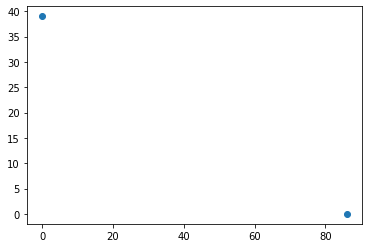

Step 2
Action:  8
obs= [86 39 86  0  0 39] reward= 10.0 done= True


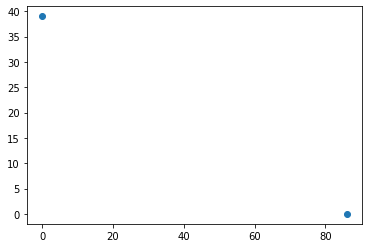

Goal reached! reward= 10.0


In [133]:
# Test the trained agent
test_states = []
test_actions = []

obs = env.reset()

n_steps = 999
for step in range(n_steps):
    test_states.append(obs)
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
    print("Action: ", action)
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)

    test_actions.append(action)

    env.render()
    if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break

In [135]:
import matplotlib.animation as animation
from IPython.display import HTML

measurements = np.array(test_actions) == 8
#=========================================
# Animate Images

fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(len(test_states)):
    x = np.array(test_states[i])[2:5:2]
    y = np.array(test_states[i])[3:6:2]
    if (measurements[i]):
        ims.append([plt.scatter(x, y, animated=True)])
        im, = plt.plot(x, y, 'ro-', animated=True)
    else:
        im = plt.scatter(x, y, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_jshtml())

In [114]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


def compute_steps(x_val, y_val, max_count=999):
        #print("x: ", x_val, "y :", y_val)
        env.reset()
        env.set_state(x_val, y_val)
        obs = env.get_state()

        for t in count():
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            if done or t > max_count:
                # Note that the VecEnv resets automatically
                # when a done signal is encountered
                #print("Goal reached!", "reward=", reward)
                return t
                

vectorized_steps = np.vectorize(compute_steps)


def test_range(x, y, max_count=999):
    X, Y = np.meshgrid(x, y)
    Z = vectorized_steps(X, Y)

    plt.pcolormesh(X, Y, Z)
    plt.colorbar()
    plt.show()

    optimal = Z < 3
    plt.pcolormesh(X, Y, optimal)
    plt.show()

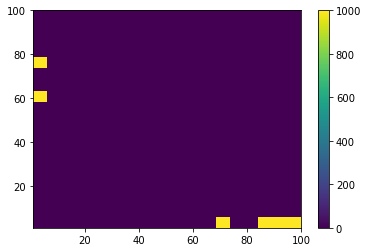

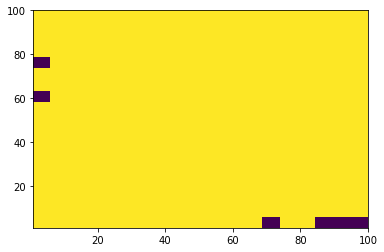

In [115]:
x_simple = y_simple = np.linspace(1, 100, 20)
test_range(x_simple, y_simple)

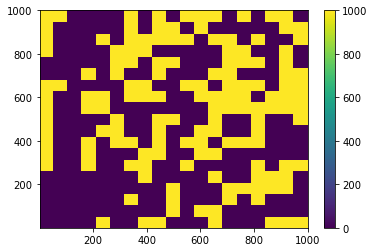

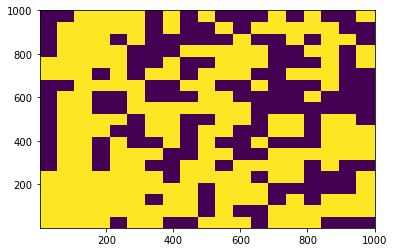

In [116]:
x_simple = y_simple = np.linspace(1, 1000, 20)
test_range(x_simple, y_simple)

In [ ]:
x_simple = y_simple = np.linspace(1, 100000, 20)
test_range(x_simple, y_simple)

In [ ]:
x_simple = y_simple = np.linspace(1, 1000000000, 20)
test_range(x_simple, y_simple)

In [ ]:
# DEFINE THE NETWORK

class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(6, 50)  # 6*6 from image dimension
        self.fc2 = nn.Linear(50, 30)
        self.head = nn.Linear(30, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization
    # Returns a distribution over the possible actions tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.float()
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x.view(-1, 30)) # self.head(x.view(x.size(0), -1))
